# Assignment 4 - dimensionality reduction

This assignment focuses on two different ways for dimensionality reduction:
* feature selection
* feature extraction

This assignment has weighting $1.5$.

# Sequential feature selection (50 points)

There is a sample code in PML chapter 4 for sequential bardward selection (SBS) and its application to subsequent KNN classifier.

Implement sequential forward selection (SFS), and compare it with sequential backward selection by plotting the accuracy versus the number of features.

You can start with the sample code provided in the [slides](http://nbviewer.jupyter.org/github/1iyiwei/pyml/blob/master/code/ch04/ch04.ipynb).
You can extend the existing SBS class to handle both forward and backward selection, or implement a separate class for SFS.
Plot and compare the two accuracy versus number-of-features plots for SFS and SBS.

Use the wine dataset as follows.

In [1]:
import pandas as pd

wine_data_remote = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
wine_data_local = '../datasets/wine/wine.data'

df_wine = pd.read_csv(wine_data_remote,
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

#print('Class labels', np.unique(df_wine['Class label']))
#df_wine.head()

In [2]:
from sklearn import __version__ as skv
from distutils.version import LooseVersion as CheckVersion
if CheckVersion(skv) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=0)

In [3]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

## Answer

Implement your sequential backward selection class here, either as a separate class or by extending the SBS class that can handle both forward and backward selection (via an input parameter to indicate the direction).

In [4]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

class SequentialSelection():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 backward = True, test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.backward = backward
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        
        all_indices = tuple(range(dim))
        self.subsets_ = []
        self.scores_ = []
     
        if self.backward: 
            self.indices_ = all_indices
            dims = range(dim, self.k_features-1, -1)
        else: # forward
            self.indices_ = []
            dims = range(1, self.k_features+1, 1)         
            
        for dim in dims:
            scores = []
            subsets = []

            if self.backward:
                p_set = [p for p in combinations(self.indices_, r=dim)]
            else:
                remaining_indices = set(all_indices).difference(self.indices_)
                p_set = [tuple(set(p).union(set(self.indices_))) for p in combinations(remaining_indices, r=1)]
            
            for p in p_set:
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            self.scores_.append(scores[best])
            
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

/Users/miracle/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Apply your sequential forward/backward selection code to the KNN classifier with the wine data set, and plot the accuracy versus number-of-features curves for both.
Describe the similarities and differences you can find, e.g. 
* do the two methods agree on the optimal number of features?
* do the two methods have similar accuracy scores for each number of features?
* etc.

## Answer

SBS and SFS give similar plots for accuracy versus the feature size, they agree on the accuracy score for 5 to 9 features based on the parameters setting used in the code.

SFS reaches a higher accuracy score than SBS with a smaller feature size. We could see from the figure that SFS has a higher accuracy of 1 with a featue size of 3 while SBS gives an accuracy of 0.96. 


In [5]:
%matplotlib inline

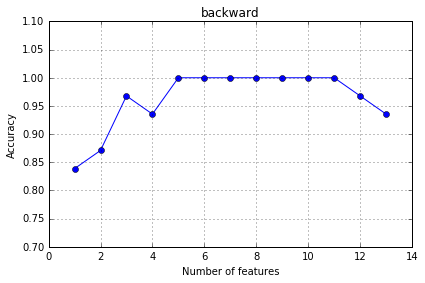

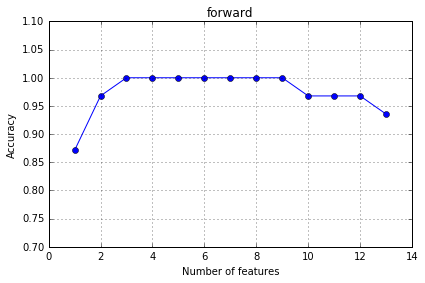

In [6]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

# selecting features
for backward in [True, False]:
    if backward:
        k_features = 1
    else:
        k_features = X_train_std.shape[1]
        
    ss = SequentialSelection(knn, k_features=k_features, backward=backward)
    ss.fit(X_train_std, y_train)

    # plotting performance of feature subsets
    k_feat = [len(k) for k in ss.subsets_]

    plt.plot(k_feat, ss.scores_, marker='o')
    plt.ylim([0.7, 1.1])
    plt.ylabel('Accuracy')
    plt.xlabel('Number of features')
    if backward:
        plt.title('backward')
    else:
        plt.title('forward')
    plt.grid()
    plt.tight_layout()
    # plt.savefig('./sbs.png', dpi=300)
    plt.show()

# PCA versus LDA (50 points)

We have learned two different methods for feature extraction, PCA (unsupervised) and LDA (supervised).

Under what circumstances would PCA and LDA produce very different results? 

Provide one example dataset in 2D, analyze it via PCA and LDA, and plot it with the PCA and LDA components.

You can use code from the scikit-learn library.

## Answer

One simple case is several very tall and narrow clusters stacked horizontally.
PCA/LDA and will favor the vertical/horizontal direction, respectively.

To avoid curing via standardization, just having enough classes so that the total/individual set is sufficiently isotropic/anisotropic.

The difference could be explained: 

PCA: 
(1) unsupervised (no class label information) 
(2) project data into dimensions that maximize variance.

LDA:
(1) supervised (with class label information) 
(2) project data into dimensions to (a) maximize inter-class spread, (b) minimize intra-class spread

In [7]:
%matplotlib inline

Write code to produce your own dataset in 2D.
You are free to design relative characteristics like the number of class, the number of samples for each class, as long as your dataset could be analyzed via PCA and LDA.

In [8]:
# visualize the data set
import numpy as np
import matplotlib.pyplot as plt

def plot_dataset(X, y, xlabel="", ylabel=""):
    num_class = np.unique(y).size
    
    colors = ['red', 'blue', 'green', 'black']
    markers = ['^', 'o', 's', 'd']
    
    if num_class <= 1:
        plt.scatter(X[:, 0], X[:, 1])
        pass
    else:
        for k in range(num_class):
            plt.scatter(X[y == k, 0], X[y == k, 1], color=colors[k], marker=markers[k], alpha=0.5)
         
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [9]:
from sklearn.datasets import make_blobs

def blobs(num_samples_per_class, dimension, num_class, cluster_std, center_spacing):
    cluster_scale = num_class*center_spacing

    class_centers = np.zeros((num_class, 2))
    for k in range(num_class):
        class_centers[k, 0] = center_spacing*(k-num_class*0.5)

    X, y = make_blobs(n_samples = num_samples_per_class*num_class, 
                      n_features = dimension, centers = class_centers,
                      cluster_std=cluster_std)

    X[:, 1] *= cluster_scale
    
    return X, y

In [10]:
def slices(num_samples_per_class, dimension, num_class, aspect_ratio=1.0):
    num_rows = num_class*num_samples_per_class
    num_cols = dimension
    
    y = np.zeros(num_rows)
    X = np.random.uniform(low=0, high=1, size=(num_rows, num_cols))
        
    for k in range(num_class):
        row_lo = k*num_samples_per_class
        row_hi = (k+1)*num_samples_per_class
        y[row_lo:row_hi].fill(k)
        X[row_lo:row_hi, 0] = (X[row_lo:row_hi, 0]+k)*aspect_ratio/num_class
            
    y = y.astype(int)        
    return X, y

In [19]:

num_samples_per_class = 100
dimension = 2
cluster_std = 1
center_spacing = 5*cluster_std

aspect_ratio = 0.8

num_class = 3

# You guys could try different dataset using blobs or slices and adjusting the angle below

#X, y = blobs(num_samples_per_class, dimension, num_class, cluster_std, center_spacing)
X, y = slices(num_samples_per_class, dimension, num_class, aspect_ratio)

print(X.shape)
print(np.unique(y))

(300, 2)
[0 1 2]


In [20]:
 class RotationMatrix():
    # angle in degree
    def __init__(self, angle=0):
        theta = (angle/180.0)*np.pi
        self.matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                                [np.sin(theta), np.cos(theta)]])
    def rot(self, X):
        return X.dot(self.matrix.transpose())

In [21]:
angle = 0

if angle != 0:
    rmat = RotationMatrix(angle)
    X = rmat.rot(X)

In [22]:
from sklearn.preprocessing import StandardScaler

if False:
    sc = StandardScaler()
    X = sc.fit_transform(X)

Plot your data set, with different classes in different marker colors and/or shapes.

You can write your own plot code or use existing library plot code.

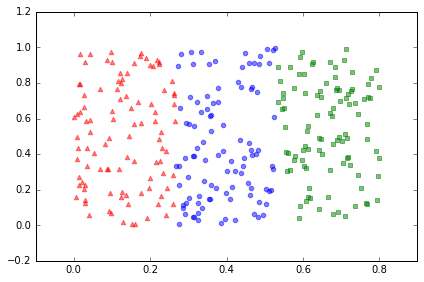

In [23]:
plot_dataset(X, y)

Apply your dataset through PCA and LDA, and plot the projected data using the same plot code.
Explain the differences you notice, and how you manage to construct your dataset to achieve such differences.

You can use the PCA and LDA code from the scikit-learn library.

In [24]:
from sklearn.decomposition import PCA

pca = PCA()
X_pca = pca.fit_transform(X)

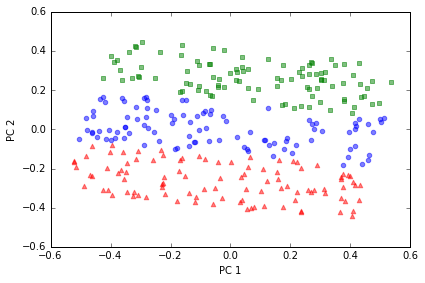

In [25]:
plot_dataset(X_pca, y, xlabel='PC 1', ylabel='PC 2')

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=dimension)
X_lda = lda.fit_transform(X, y)

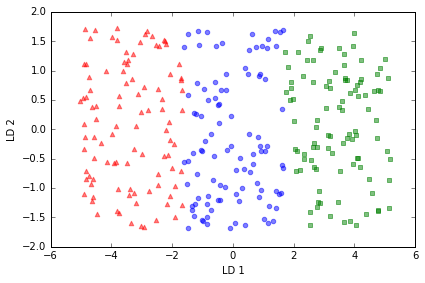

In [27]:
plot_dataset(X_lda, y, xlabel = "LD 1", ylabel = "LD 2")